## 3. CRISP-DM: Data Understanding

In [312]:

# imports

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime
from IPython.display import display
import re
import os
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix, roc_auc_score, roc_curve, accuracy_score
from IPython.display import display, Markdown
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import DBSCAN
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from geopy.distance import geodesic

from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV, KFold
from sklearn.preprocessing import PolynomialFeatures, StandardScaler


from imblearn.over_sampling import SMOTE 
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, AdaBoostClassifier, ExtraTreesClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.metrics import roc_auc_score, confusion_matrix, recall_score, precision_score, roc_curve, f1_score

%matplotlib inline
%config InlineBackend.figure_format = 'retina' # Render high resolution images

# Load datasets
train = pd.read_csv('../data/train.csv')
test = pd.read_csv('../data/test.csv')
weather = pd.read_csv('../data/weather.csv')
spray = pd.read_csv('../data/spray.csv')


### 3.1 Data Description
Die Daten für die Analyse stammen aus dem Wettbewerb „Predict West Nile Virus“ aus dem Jahr 2015 auf Kaggle. Sie liegen in vier CSV-Dateien vor und umfassen verschiedene Datensätze. Der Hauptdatensatz besteht aus Trainings- und Testdaten. Die Trainingsdatensätze umfassen insgesamt 10.506 Datensätze aus den Jahren 2007, 2009, 2011 und 2013. Der Testdatensatz umfasst die Jahre 2008, 2010, 2012 und 2014 und enthält insgesamt 116.293 Datensätze. Jeder Datensatz enthält das Datum des Tests (Date), eine ungefähre Adresse des Standorts der Falle (Address), die Mückenart (Species), die Blocknummer der Adresse (Block), den Straßennamen (Street) und eine ID der Falle (Trap). Darüber hinaus werden geografische Informationen in Breitengrad (Latitude) und Längengrad (Longitude) umgewandelt. Die Genauigkeit dieser Geokodierung wird im Feld „AddressAccuracy“ angegeben. Zusätzlich wird die Anzahl der in der jeweiligen Falle gefangenen Stechmücken (NumMosquitos) angegeben. Das entscheidende Merkmal dieser Daten ist jedoch „WnvPresent“, das angibt, ob das West-Nil-Virus in den gefangenen Mücken vorhanden war oder nicht (1 = vorhanden, 0 = nicht vorhanden). Dieses Feld ist die Zielvariable im Vorhersagemodell.

Zusätzlich werden noch Wetterdatensätze aus der NOAA (National Weather Service) beigefügt. Diese umfassen 2.945 Wetterdatensätze zwischen Mai 2007 und Oktober 2014, die von zwei Wetterstationen stammen und verschiedene Wetterbedingungen wie z. B. die Tages-Maximaltemperatur (Tmax), den durchschnittlichen Taupunkt (DewPoint) oder die Niederschlagsmenge (PrecipTotal) an den verschiedenen Tagen dokumentieren. Als Maßnahmen zur Mückenbekämpfung werden in den Sprühdatensätzen Daten über Sprühaktionen dokumentiert. Die Sprühdatensätze umfassen das Datum und den Zeitpunkt der gesprühten Orte aus den Jahren 2011 bis 2013. Die Orte sind in GIS-Daten, also Longitude und Latitude, angegeben.


### 3.2 Attribute Understanding

**Wetterdaten**

| **Attribut**   | **Dimension**          | **Beschreibung**                                                                                                                                                                                                                     |
|----------------|------------------------|--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------|
| **Station**    | Kategorisch: 1, 2      | Messstation <br> 1 = CHICAGO O'HARE INTERNATIONAL AIRPORT Lat: 41.995 Lon: -87.933 Elev: 662 ft. above sea level <br> 2 = CHICAGO MIDWAY INTL ARPT Lat: 41.786 Lon: -87.752 Elev: 612 ft. above sea level                           |
| **Date**       | Datum: DD-MM-YYYY      | Tag der Messung                                                                                                                                                                                                                      |
| **Tmax**       | Integer                | Tages-Maximal-Temperatur, in Fahrenheit                                                                                                                                                                                              |
| **Tmin**       | Integer                | Tages-Minimal-Temperatur, in Fahrenheit                                                                                                                                                                                              |
| **Tavg**       | Integer                | Tages-Durchschnittstemperatur, in Fahrenheit                                                                                                                                                                                         |
| **Depart**     | Integer                | Abweichung Temperaturwertes vom langjährigen Durchschnitt oder Normalwert für denselben Zeitraum                                                                                                                                     |
| **DewPoint**   | Integer                | Durchschnittlicher Taupunkt (Temperatur, bei der die Luft vollständig gesättigt ist und Wasser zu kondensieren beginnt)                                                                                                               |
| **WetBulb**    | Integer                | Durchschnittliche Kühlgrenztemperatur (niedrigste Temperatur, die durch Verdunstungskühlung erreicht werden kann)                                                                                                                     |
| **Heat**       | Integer                | Heizgradtage (Differenz zwischen Tages-Durchschnittstemperatur und festgelegter Heizgrenze (65°F), Temperatur ist geringer als Durchschnittstemperatur), in Fahrenheit                                                               |
| **Cool**       | Integer                | Kühlgradtage (Differenz zwischen Tages-Durchschnittstemperatur und festgelegter Heizgrenze (65°F), Temperatur ist höher als Durchschnittstemperatur), in Fahrenheit                                                                  |
| **Sunrise**    | Integer                | berechneter Sonnenaufgang                                                                                                                                                                                                            |
| **Sunset**     | Integer                | berechneter Sonnenuntergang                                                                                                                                                                                                          |
| **CodeSum**    | Kategorisch            | Wetterart: <br> FC TORNADO/WATERSPOUT <br> FC  FUNNEL CLOUD <br> TS  THUNDERSTORM <br> GR  HAIL <br> RA  RAIN <br> DZ  DRIZZLE <br> SN  SNOW <br> SG  SNOW GRAINS <br> GS  SMALL HAIL &/OR SNOW PELLETS <br> PL  ICE PELLETS <br> IC  ICE CRYSTALS <br> FG+ HEAVY FOG (FG & LE.25 MILES VISIBILITY) <br> FG  FOG <br> BR  MIST <br> UP  UNKNOWN PRECIPITATION <br> HZ  HAZE <br> FU  SMOKE <br> VA  VOLCANIC ASH <br> DU  WIDESPREAD DUST <br> DS  DUSTSTORM <br> PO  SAND/DUST WHIRLS <br> SA  SAND <br> SS  SANDSTORM <br> PY  SPRAY <br> SQ  SQUALL  <br> DR  LOW DRIFTING <br> SH  SHOWER <br> FZ  FREEZING <br> MI  SHALLOW <br> PR  PARTIAL <br> BC  PATCHES <br> BL  BLOWING <br> VC  VICINITY <br> -   LIGHT <br> +   HEAVY <br> "NO SIGN" MODERATE    |
| **Depth**      | Integer                | Schneetiefe (in Zoll)                                                                                                                                                                                                                |
| **Water1**     | Integer?               | Wasseräquivalent des Schnees am Boden                                                                                                                                                                                                |
| **SnowFall**   | Float                  | Schneemange (Tiefe), T = Trace, M = missing data                                                                                                                                                                                     |
| **PrecipTotal**| Float                  | Menge an Niederschlag                                                                                                                                                                                                                |
| **StnPressure**| Float                  | Stattionsdruck; Luftdruck, der direkt an der Wetterstation gemessen wird, in Zoll Hg                                                                                                                                                  |
| **SeaLevel**   | Float                  | Luftdruck auf Meereshöhe                                                                                                                                                                                                             |
| **ResultSpeed**| Float                  | Windgeschwindigkeit in mph                                                                                                                                                                                                           |
| **ResultDir**  | Integer                | Windrichtung in Kompassgeraden                                                                                                                                                                                                       |
| **AvgSpeed**   | Float                  | Durchschnittliche Windgeschwindigkeit                                                                                                                                                                                                |


**Spray-Daten**


| **Attribut**  | **Dimension**    | **Beschreibung**                   |
|---------------|------------------|------------------------------------|
| **Date**      | Datum, DD-MM-YYYY| Datum, wann gesprüht wurde         |
| **Time**      | Zeit, hh:mm:ss   | Zeit, wann gesprüht wurde          |
| **Latitude**  | Breitengrad      | Breitengrad, wo gesprüht wurde     |
| **Longitude** | Längengrad       | Längengrad, wo gesprüht wurde      |


**Trainingsdaten**

| **Attribut**                | **Dimension**          | **Beschreibung**                                                                                               |
|-----------------------------|------------------------|---------------------------------------------------------------------------------------------------------------|
| **Date**                    | Datum, DD-MM-YYYY      | Datum, an dem der WNV-Test durchgeführt wird                                                                  |
| **Address**                 | String                 | Ungefähre Adresse des Standorts der Falle                                                                     |
| **Species**                 | String                 | Stechmückenart                                                                                                 |
| **Block**                   | Integer                | Blocknummer der Adresse                                                                                       |
| **Street**                  | String                 | Straßenname                                                                                                   |
| **Trap**                    | Kategorisch?           | ID der Falle                                                                                                  |
| **AddressNumberAndStreet**  | String                 | Ungefähre Adresse, die von GeoCoder zurückgegeben wurde                                                       |
| **Latitude**                | Float                  | Breitengrad, vom GeoCoder zurückgegeben                                                                       |
| **Longitude**               | Float                  | Längengrad, vom GeoCoder zurückgegeben                                                                        |
| **AddressAccuracy**         | Integer                | Von GeoCoder zurückgegebene Genauigkeit                                                                       |
| **NumMosquitos**            | Integer                | Anzahl der in dieser Falle gefangenen Stechmücken                                                             |
| **WnvPresent**              | Boolean                | Ob das West-Nil-Virus in diesen Mücken vorhanden war. 1 = ist vorhanden, 0 = ist nicht vorhanden               |


### 3.3 Data Quality





**weather.csv**

Die Daten von folgenden Attributen sind entweder unvollständig oder fragwürdig.


| Attribute    | Fehlende Werte       | Bemerkung                                |
|--------------|----------------------|------------------------------------------|
| Tavg         | 11                   |                                          |
| Depart       | 1.472                | Daten nur aus Station 2                            |
| WetBulb      | 4                    |                                          |
| Heat         | 11                   |                                          |
| Cool         | 11                   |                                          |
| Sunrise      | 1.472                | Daten nur aus Station 2                            |
| Sunset       | 1.472                | Daten nur aus Station 2                            |
| CodeSum      | 1.609                |                                          |
| Depth        | 1.472                | Daten nur aus Station 2                            |
| Water        | 2.944 (alle)         |                                          |
| Snowfall     | 1.472                | Daten nur aus Station 2                            |
| StnPressure  | 4                    |                                          |
| SeaLevel     | 9                    |                                          |
| AvgSpeed     | 3                    |                                          |
| StnPressure  | vollständig          |158 Aufzeichnungen, die 0 oder T anzeigen, aber in den Wetterarten(CodeSum) eindeutig als Regenfälle (mit RA, DZ, SH) aufgeführt sind|       

**spray.csv**

Nur die Daten "Time" sind nicht vollständig und es fehlt 584 Daten


**train.csv & test.csv**

Die Daten aus den zwei Tabellen sind vollständig, aber bei Test-Data gibt es ein unklare Species "UNSPECIFIED CULEX".


### 3.4 Data Visualization

##### Abhängigkeit der WNV-Präsenz von Moskitoanzahl und Temperatur

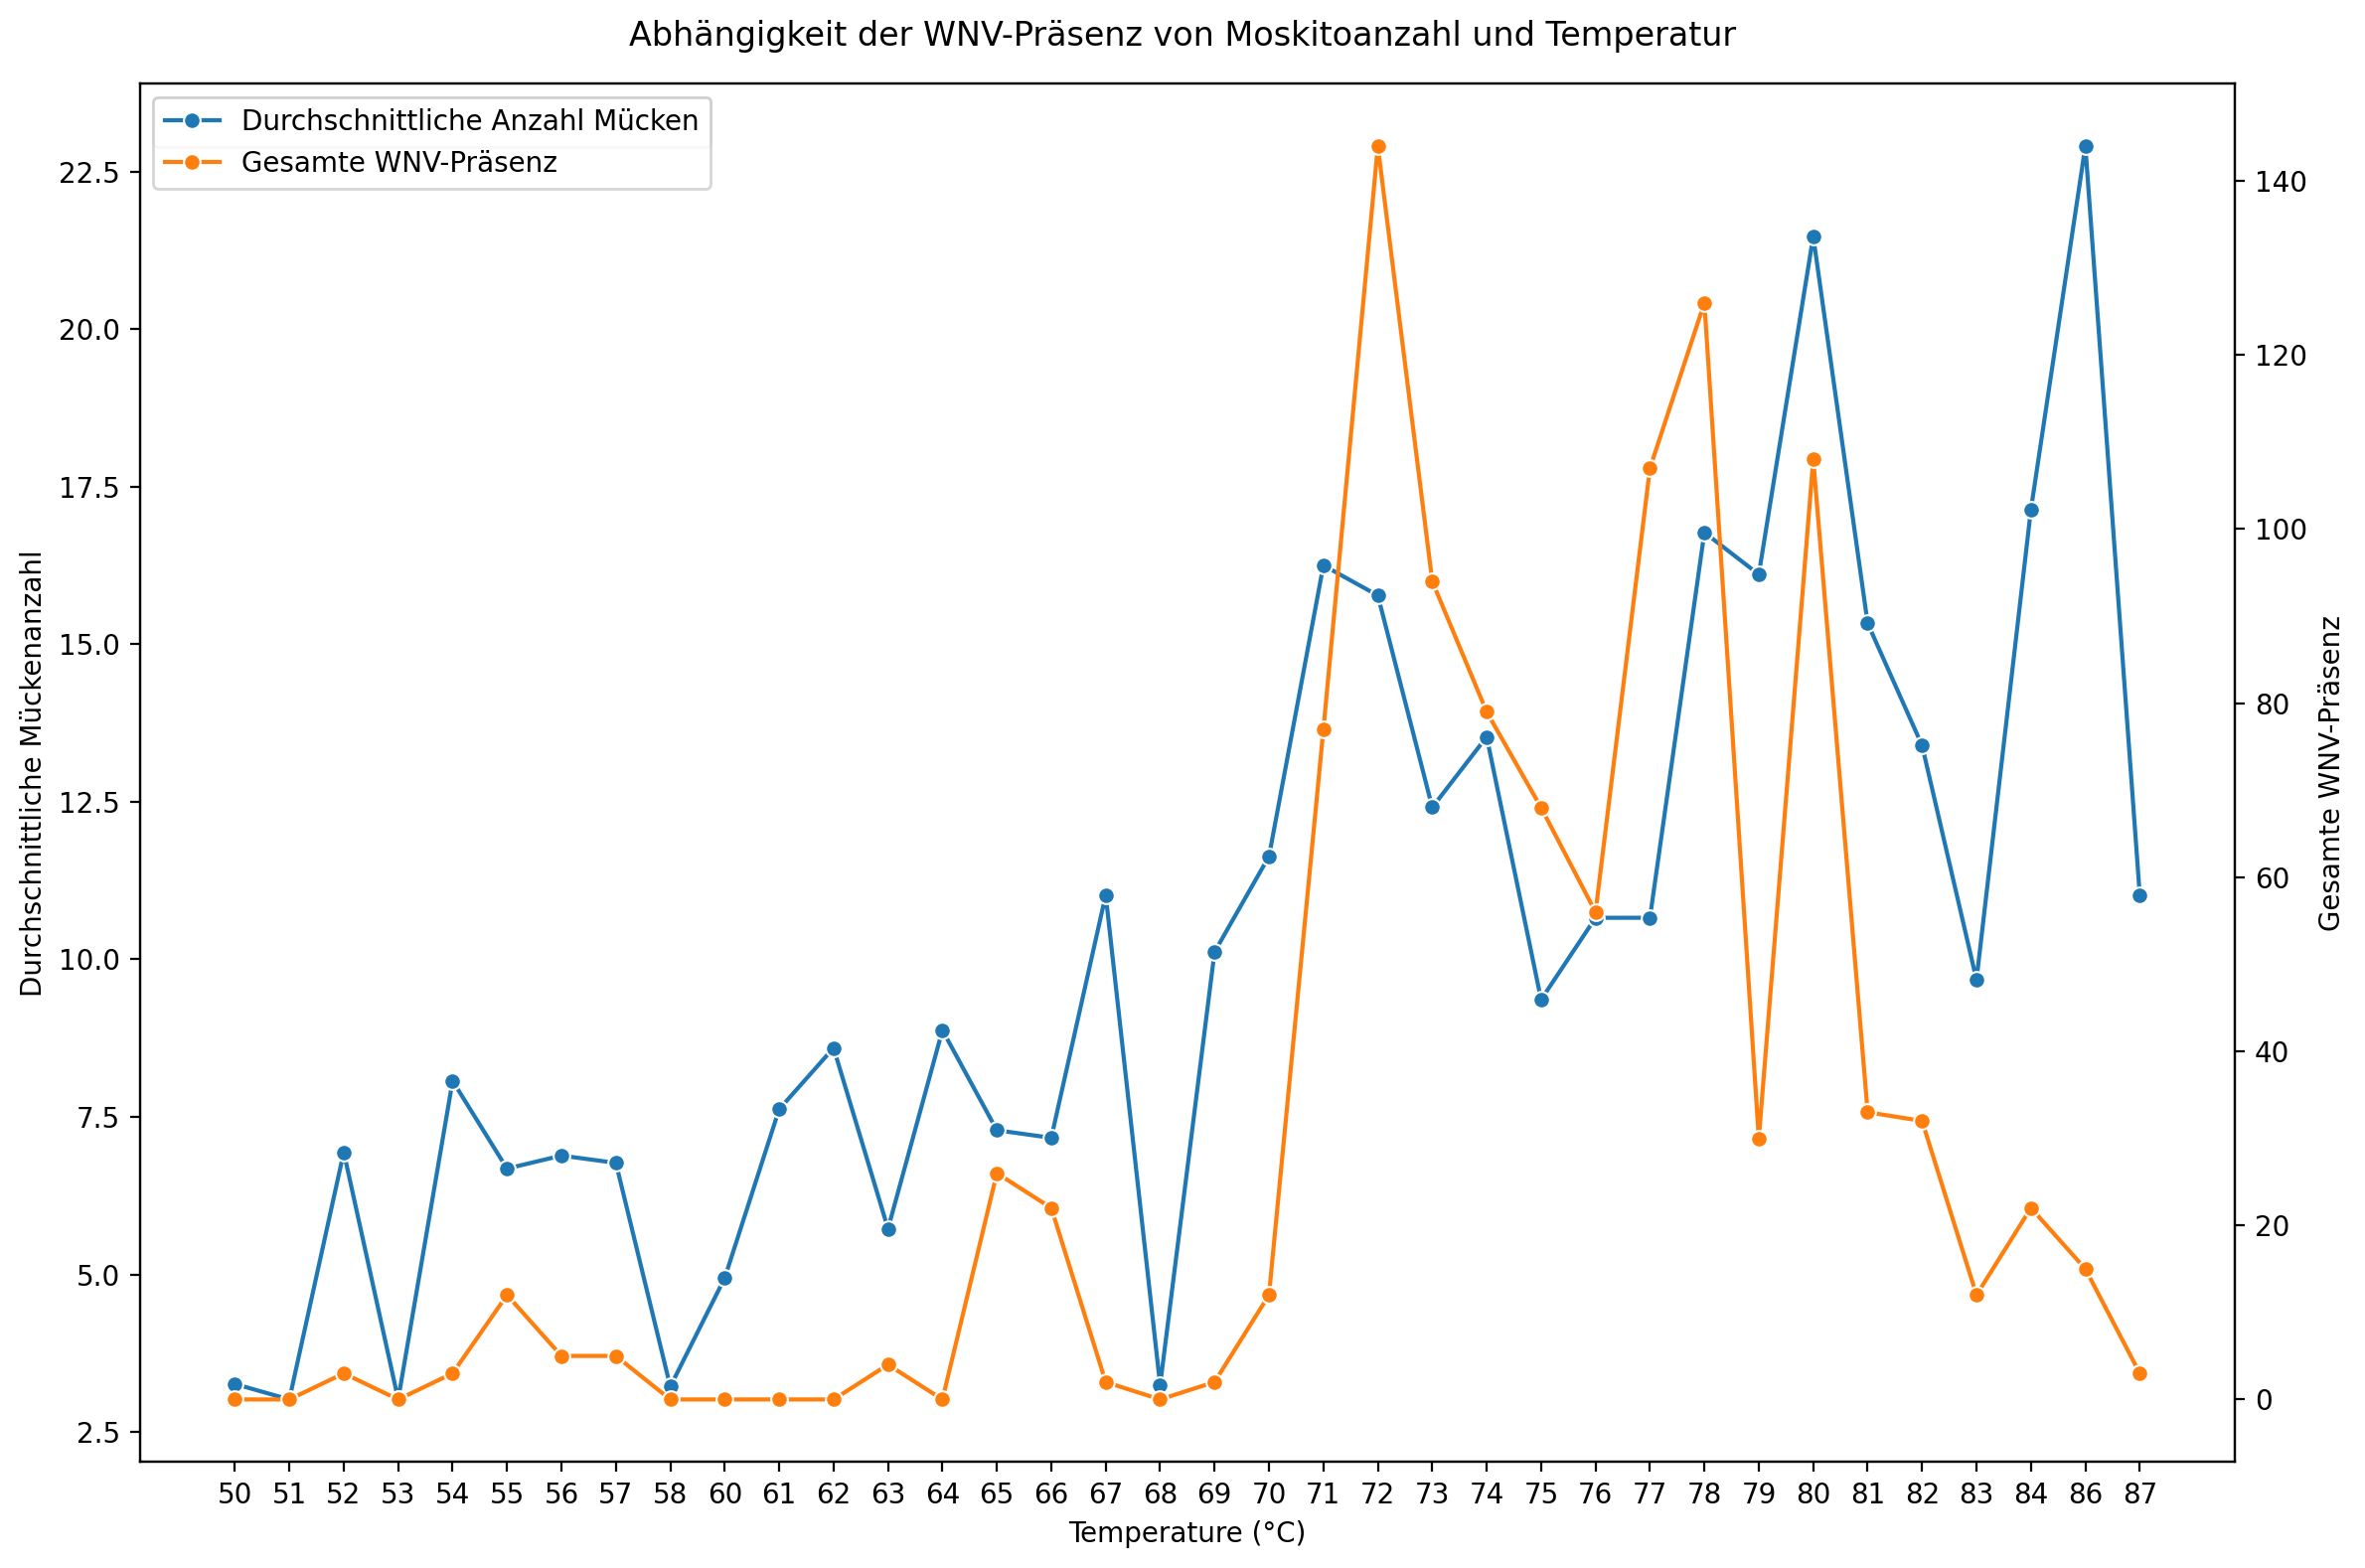

In [313]:
# Dateien einlesen
mosquito_data_path = '../data/train.csv'
weather_data_path = '../data/weather.csv'

# Dataframe erstellen
mosquito_df = pd.read_csv(mosquito_data_path)
weather_df = pd.read_csv(weather_data_path)

# Konvertieren von 'Date' in Datetime-Format
mosquito_df['Date'] = pd.to_datetime(mosquito_df['Date'], format='%Y-%m-%d')
weather_df['Date'] = pd.to_datetime(weather_df['Date'])

if 'Tavg' in weather_df.columns:
    weather_df['Temp'] = weather_df['Tavg']
else:
    # Durchschnittstemperatur berechnen (falls Min/Max-Temperatur vorhanden)
    if 'Tmax' in weather_df.columns and 'Tmin' in weather_df.columns:
        weather_df['Temp'] = (weather_df['Tmax'] + weather_df['Tmin']) / 2
    else:
        raise ValueError("Keine Temperaturdaten gefunden")

# Merge Datensätze auf Basis des Datums
merged_df = pd.merge(mosquito_df, weather_df[['Date', 'Temp']], on='Date')

# Konvertieren von 'NumMosquitos' in Integer
merged_df['NumMosquitos'] = merged_df['NumMosquitos'].astype(int)

# Berechnen des Durchschnitts der Anzahl der Mücken und der WnvPresence für jede Temperatur
avg_values_per_temp = merged_df.groupby('Temp').agg({'NumMosquitos': 'mean', 'WnvPresent': 'sum'}).reset_index()

# Plot erstellen
fig, ax1 = plt.subplots(figsize=(12, 8))

# Durchschnitt Mückenanzahl
color = 'tab:blue'
ax1.set_xlabel('Temperature (°C)')
ax1.set_ylabel('Durchschnittliche Mückenanzahl')
sns.lineplot(data=avg_values_per_temp, x='Temp', y='NumMosquitos', marker='o', ax=ax1, color=color, label='Durchschnittliche Anzahl Mücken')
ax1.tick_params(axis='y')

# Zweite Y-Achse für WnvPresence
ax2 = ax1.twinx()
color = 'tab:orange'
ax2.set_ylabel('Gesamte WNV-Präsenz')
sns.lineplot(data=avg_values_per_temp, x='Temp', y='WnvPresent', marker='o', ax=ax2, color=color, label='Gesamte WNV-Präsenz')
ax2.tick_params(axis='y')

# Titel 
fig.suptitle('Abhängigkeit der WNV-Präsenz von Moskitoanzahl und Temperatur')

# Legenden 
lines_1, labels_1 = ax1.get_legend_handles_labels()
lines_2, labels_2 = ax2.get_legend_handles_labels()
ax2.legend(lines_1 + lines_2, labels_1 + labels_2, loc='upper left')

fig.tight_layout()
plt.show()

##### Mückenart und WNV-Präsenz

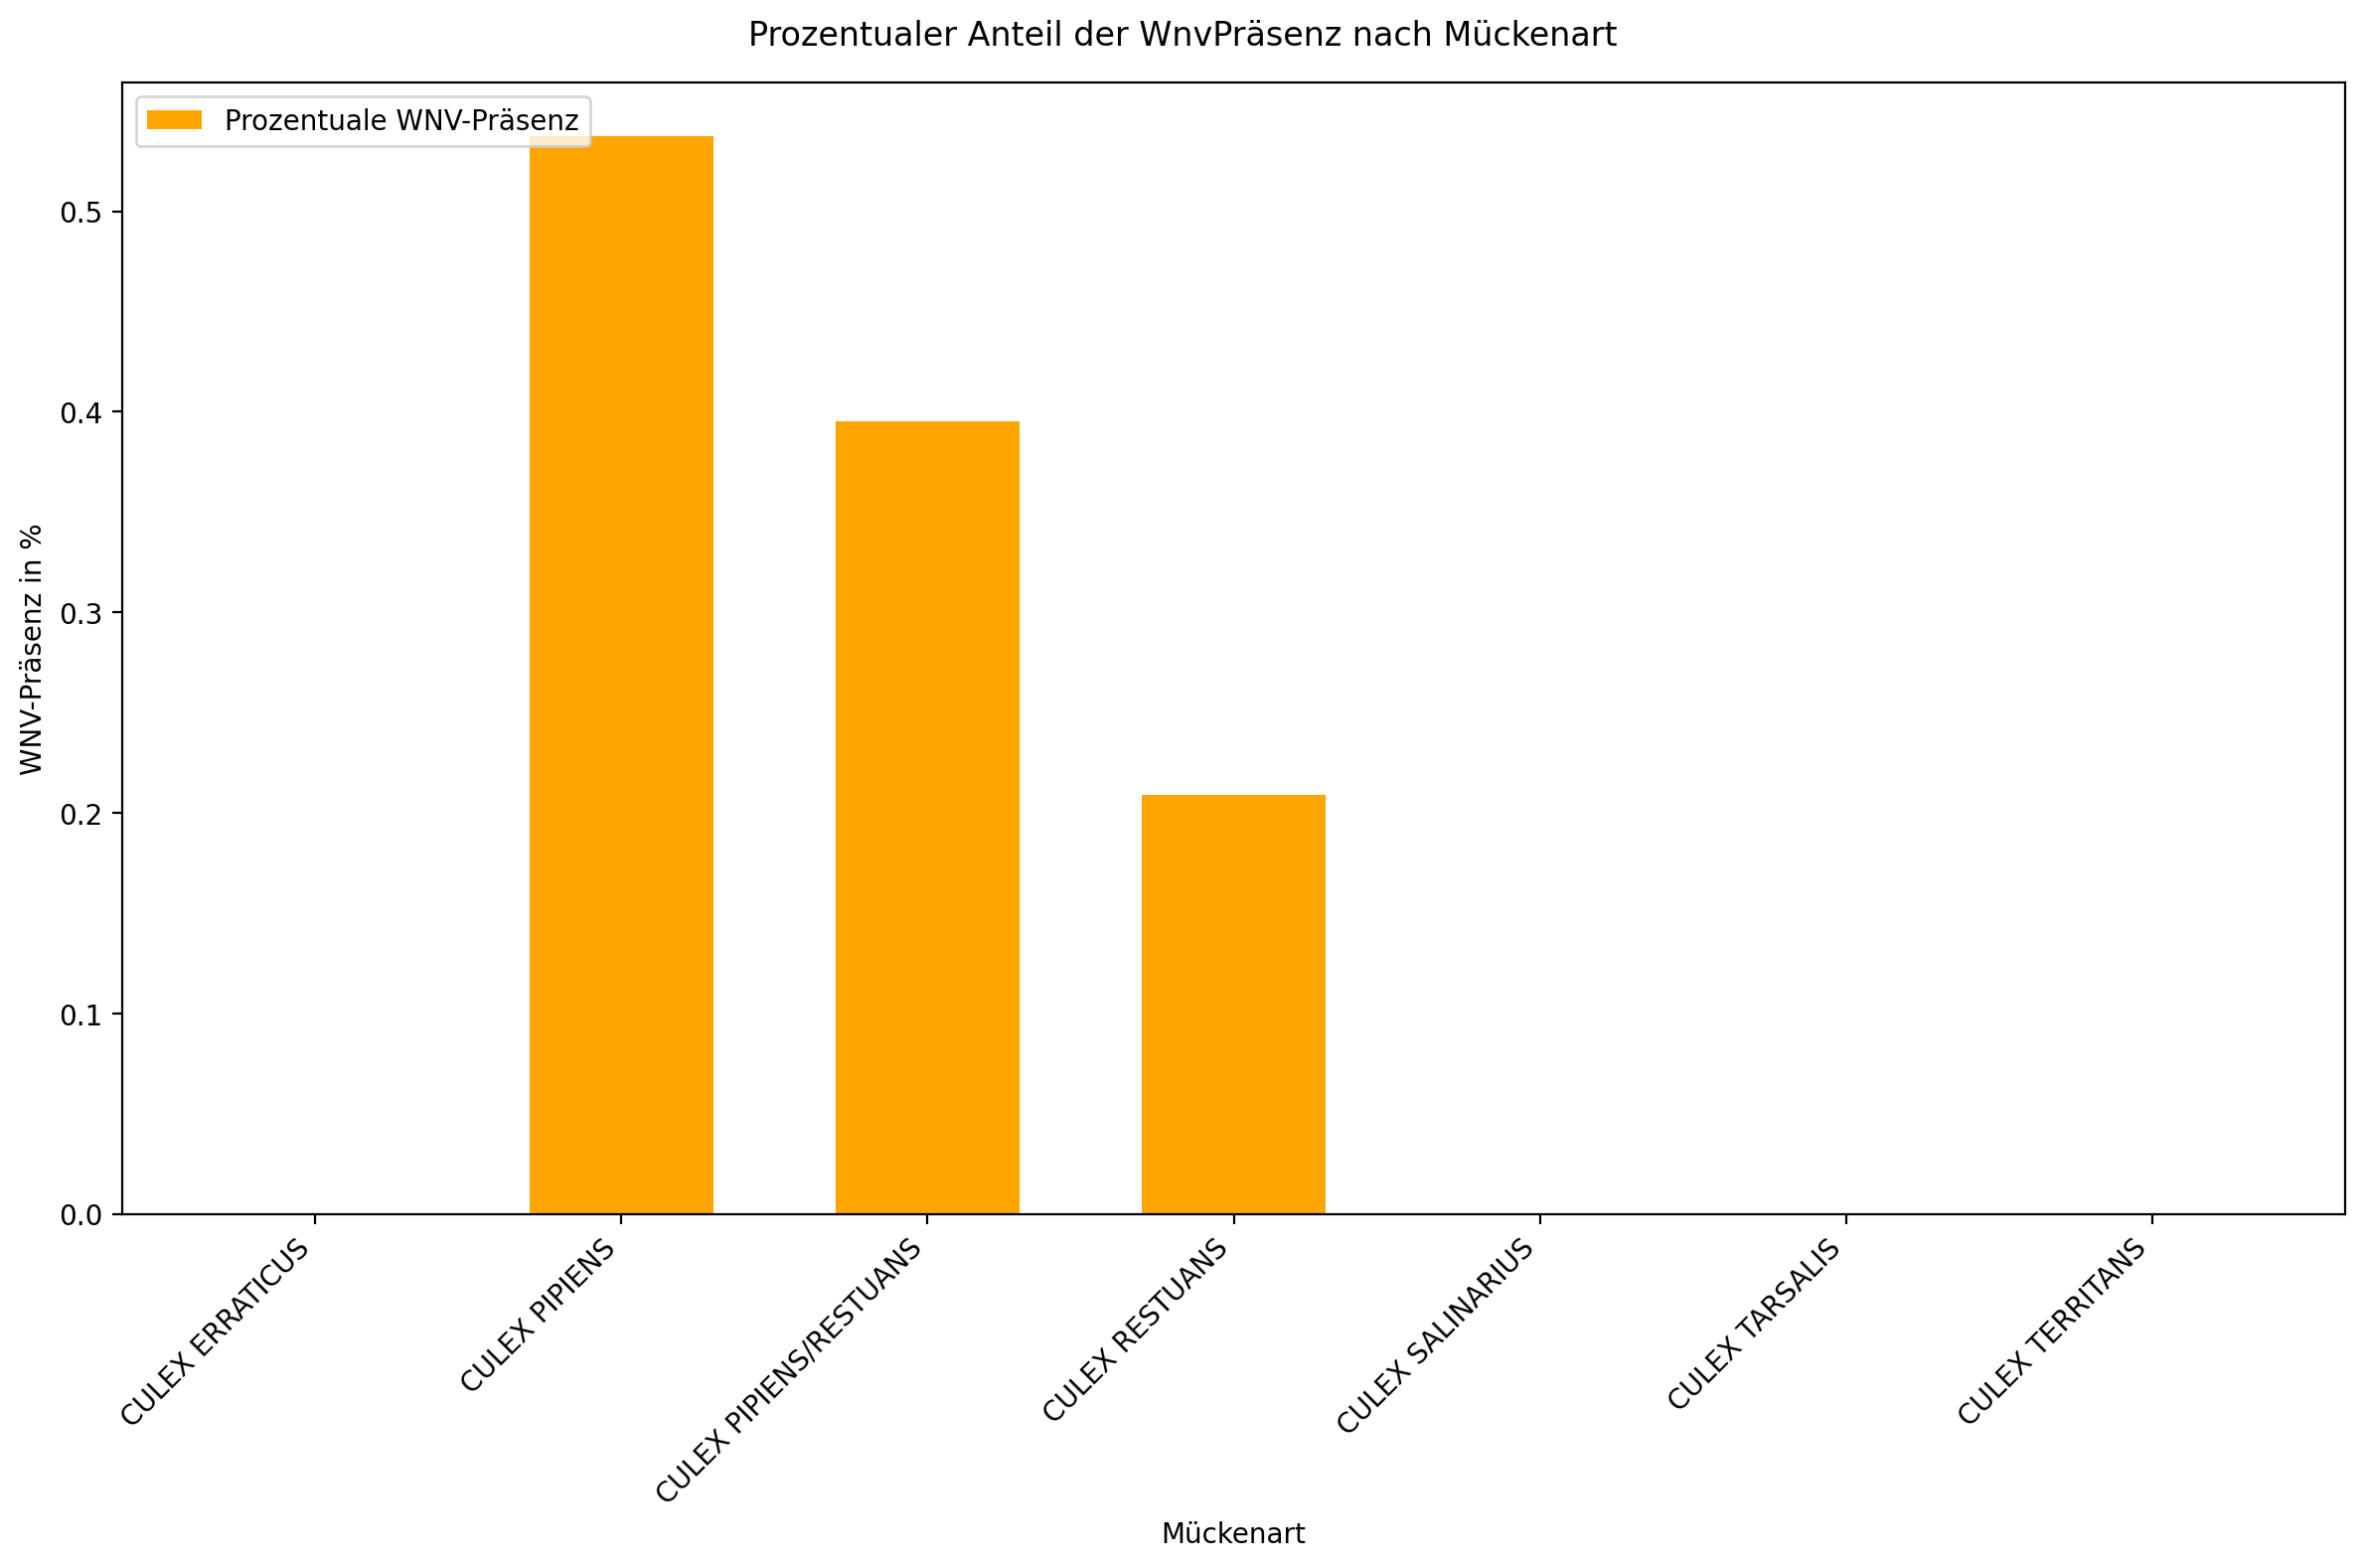

In [314]:
# Datei einlesen
file_path = '../data/train.csv'
df = pd.read_csv(file_path)

# Konvertieren von 'NumMosquitos' und 'WnvPresent' in Integer
df['NumMosquitos'] = df['NumMosquitos'].astype(int)
df['WnvPresent'] = df['WnvPresent'].astype(int)

# Gruppieren nach 'Species' und Aggregieren der Summen
species_counts = df.groupby('Species').agg({'NumMosquitos': 'sum', 'WnvPresent': 'sum'}).reset_index()

# Berechnung des prozentualen Anteils der WnvPresence pro Spezies
species_counts['WnvPresencePercentage'] = (species_counts['WnvPresent'] / species_counts['NumMosquitos']) * 100

# Balkendiagramm erstellen
fig, ax = plt.subplots(figsize=(12, 8))

bar_width = 0.6
index = np.arange(len(species_counts))

# Balken für den prozentualen Anteil der WnvPresence
bars = ax.bar(index, species_counts['WnvPresencePercentage'], bar_width, label='Prozentuale WNV-Präsenz', color='orange')
ax.set_xlabel('Mückenart')
ax.set_ylabel('WNV-Präsenz in %')
ax.tick_params(axis='y')

# Achsenbeschriftungen und Titel setzen
ax.set_xticks(index)
ax.set_xticklabels(species_counts['Species'], rotation=45, ha='right')
fig.suptitle('Prozentualer Anteil der WnvPräsenz nach Mückenart')

# Legende hinzufügen
ax.legend(loc='upper left')

fig.tight_layout()
plt.show()

##### Übersicht Vorkommen der Mückenarten

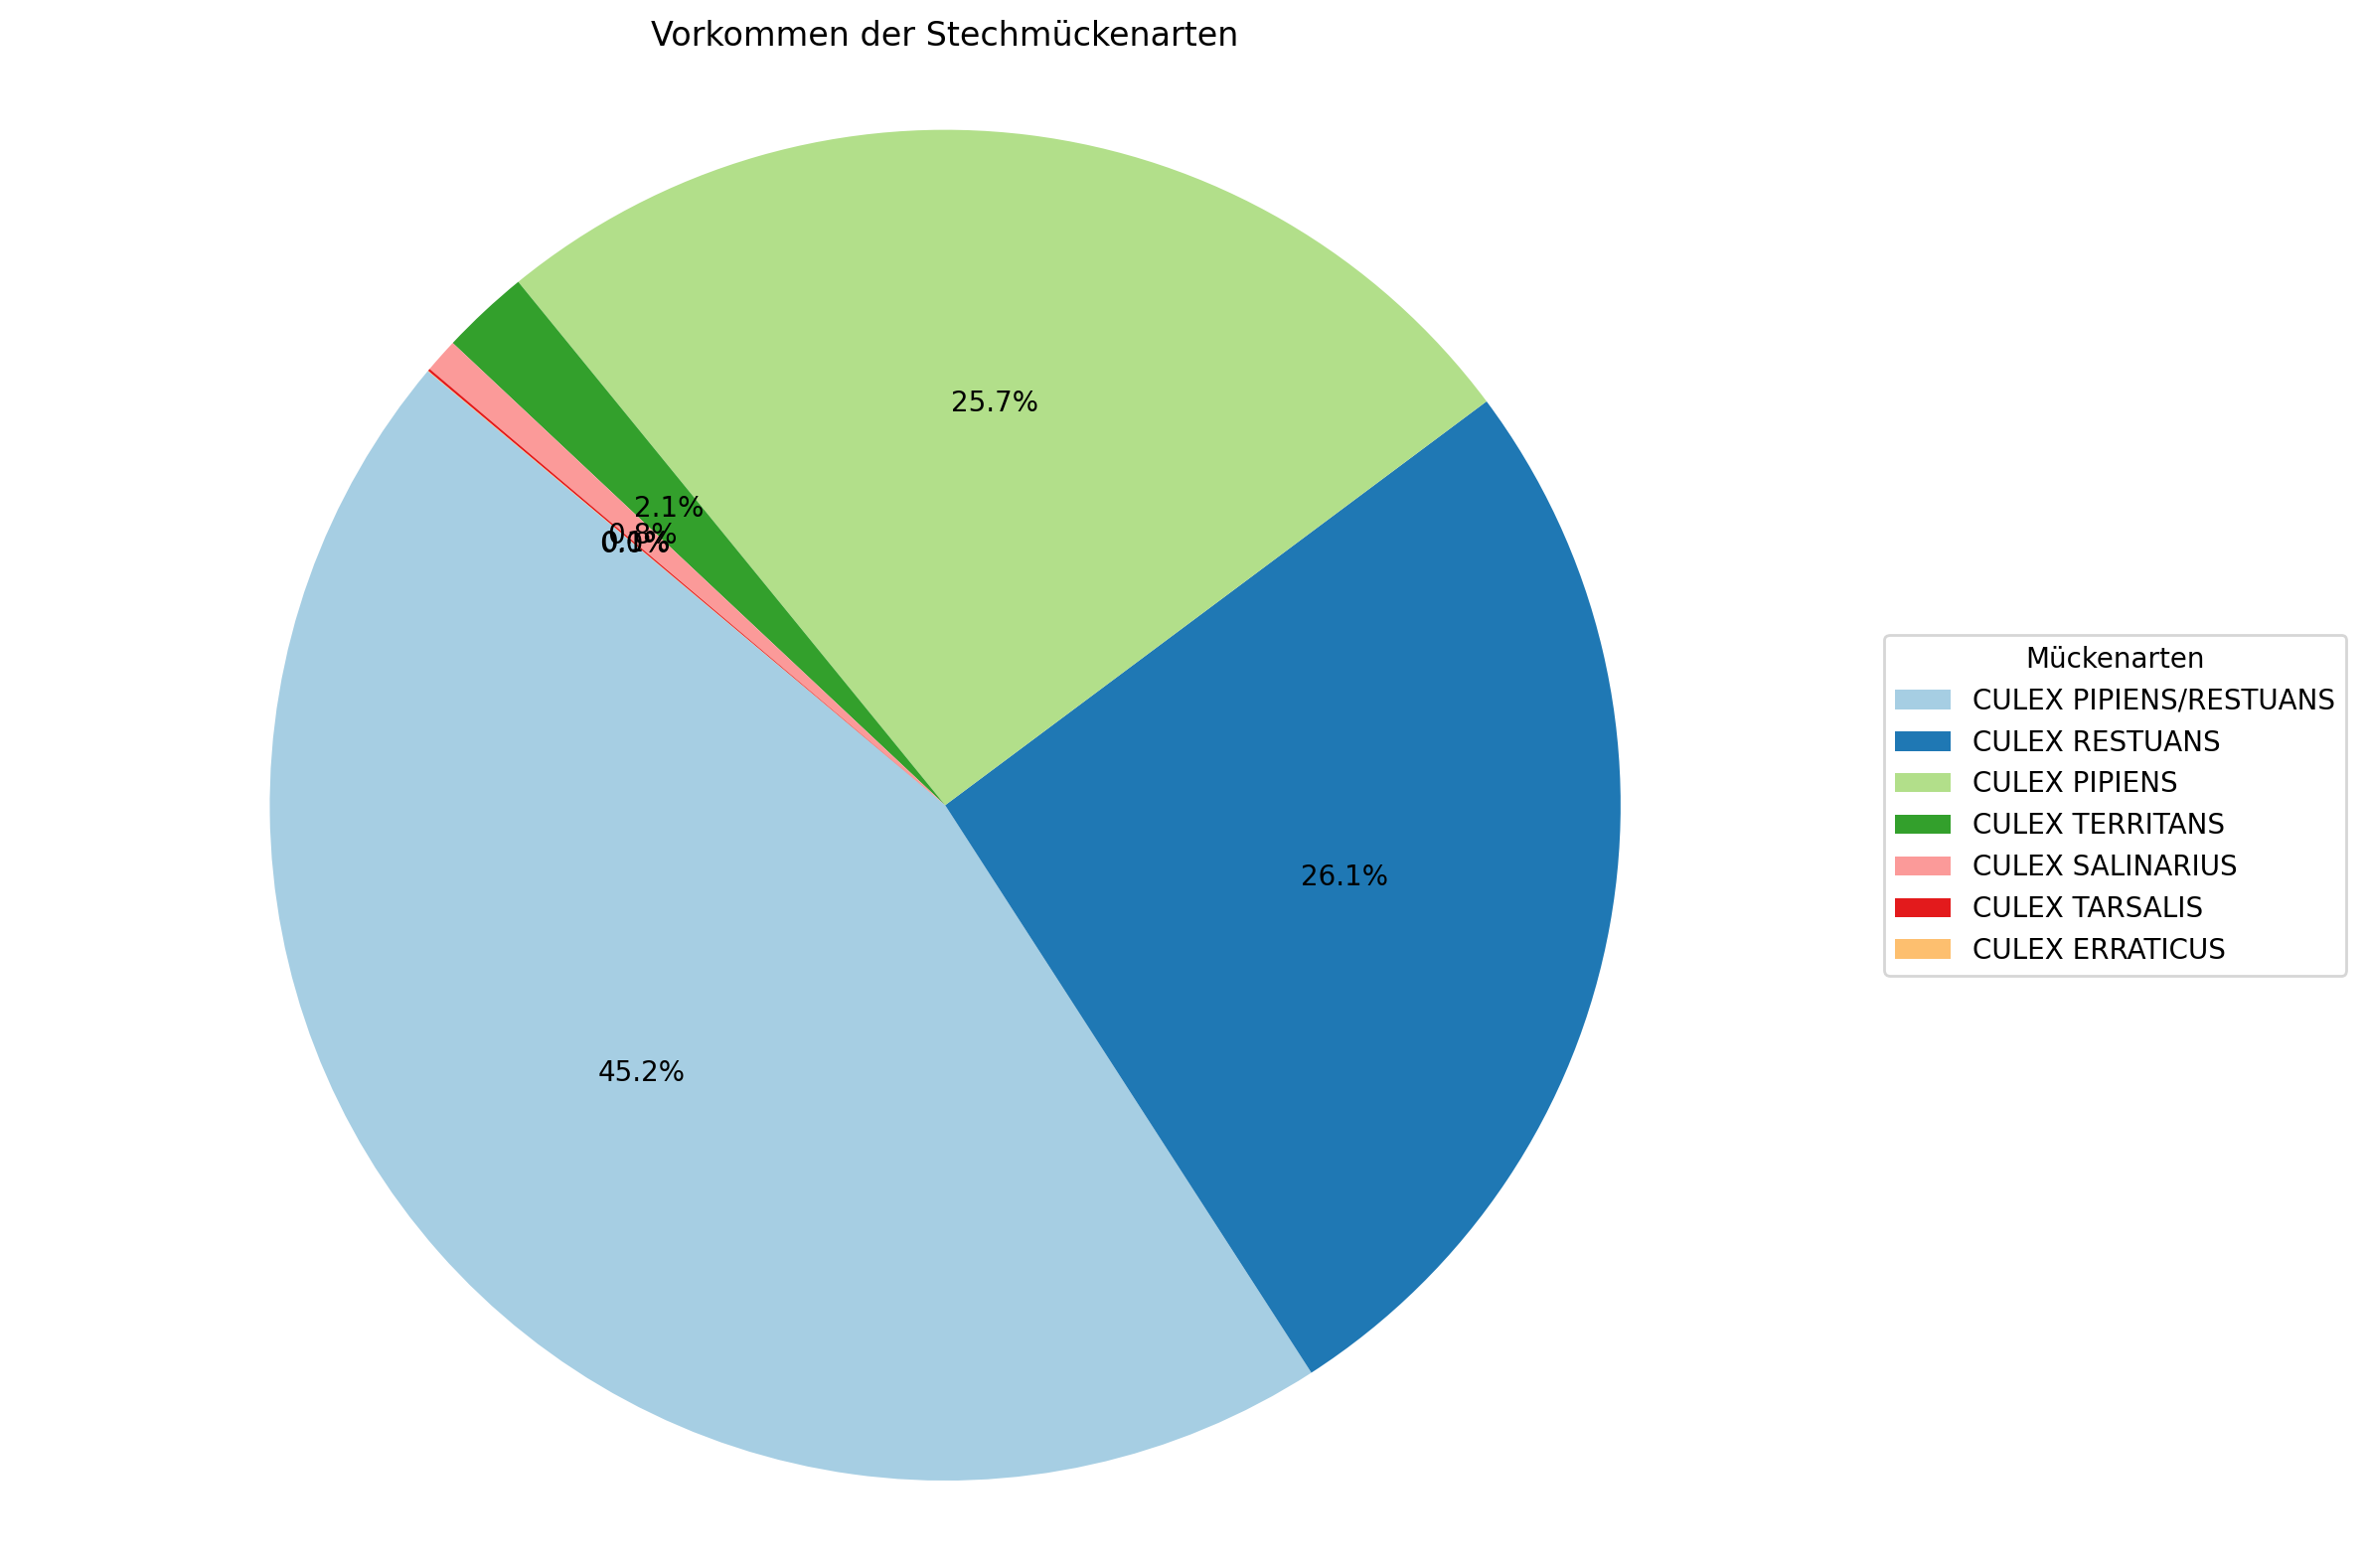

In [315]:
# Datei einlesen und Delimiter setzen
file_path = '../data/train.csv'  # Passen Sie den Pfad zur Datei an
df = pd.read_csv(file_path)

# Gruppieren nach 'Species' und Zählen der Vorkommen
species_counts = df['Species'].value_counts()

# Kuchendiagramm erstellen
plt.figure(figsize=(12, 8))
wedges, texts, autotexts = plt.pie(species_counts, autopct='%1.1f%%', startangle=140, colors=plt.cm.Paired.colors)

# Legende hinzufügen
plt.legend(wedges, species_counts.index, title='Mückenarten', loc='center left', bbox_to_anchor=(1, 0, 0.5, 1))

plt.title('Vorkommen der Stechmückenarten')
plt.axis('equal')  # Gleichmäßige Darstellung
plt.tight_layout()
plt.show()

##### Mückenanzahl über Jahre

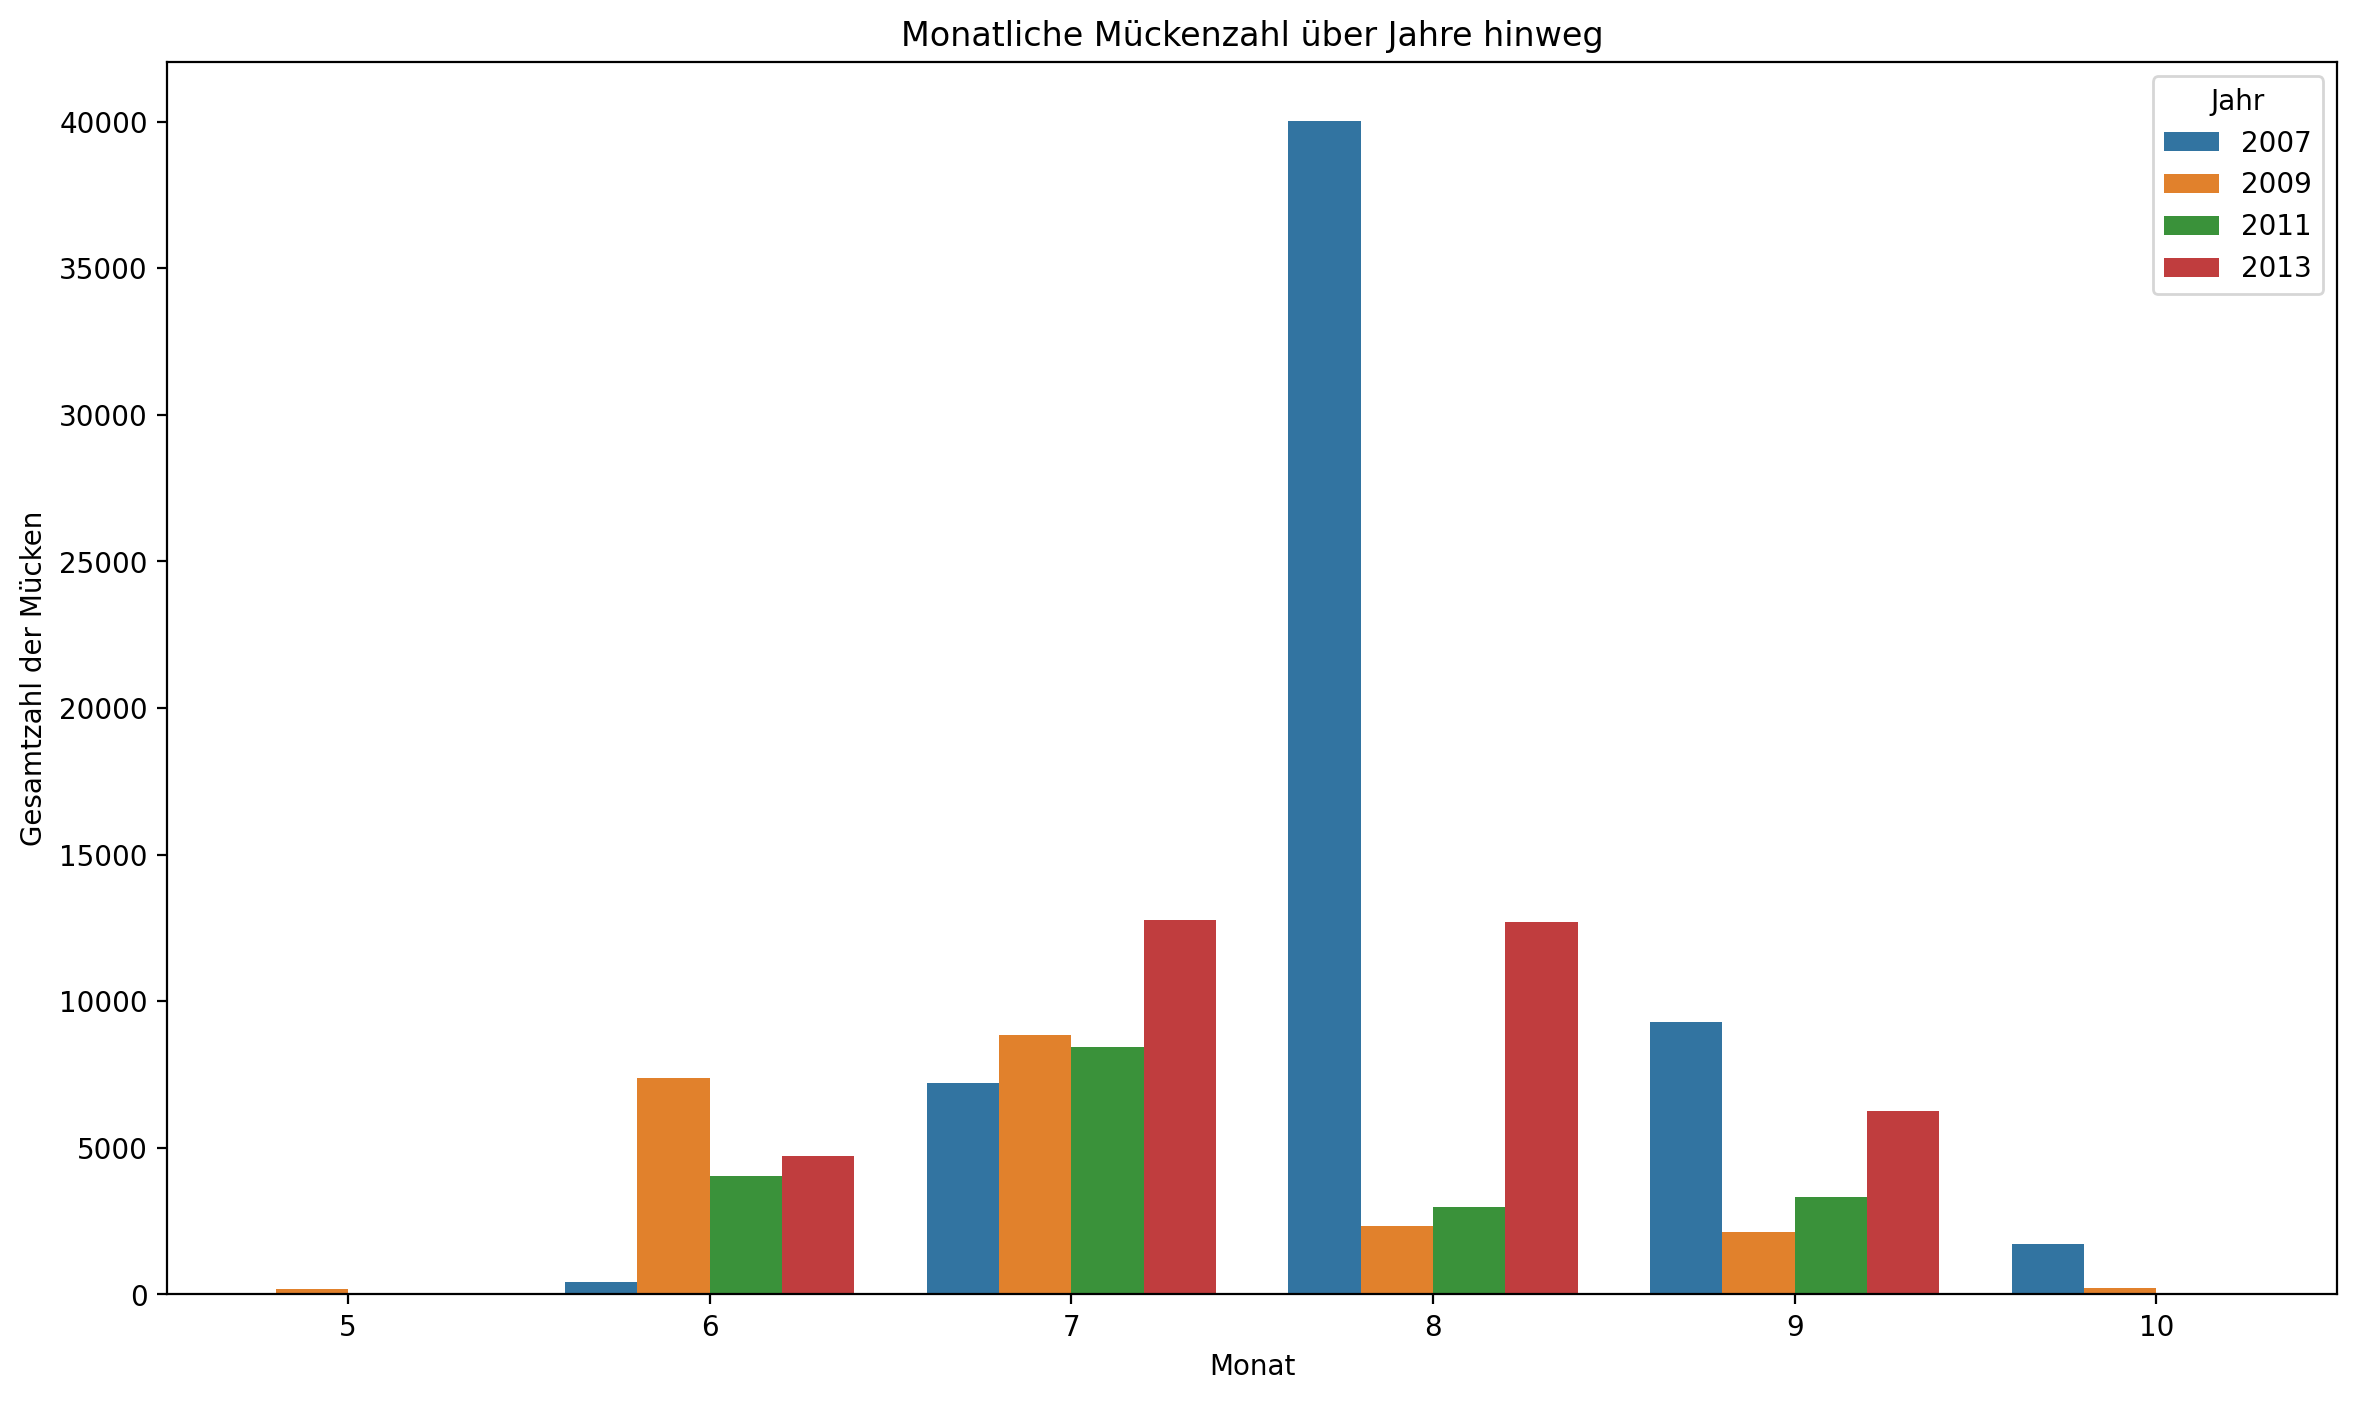

In [316]:
# Datei einlesen und Delimiter setzen
file_path = '../data/train.csv'  # Passen Sie den Pfad zur Datei an
df = pd.read_csv(file_path)

# Konvertieren der 'Date'-Spalte in Datetime-Format
df['Date'] = pd.to_datetime(df['Date'], format='%Y-%m-%d')

# Extrahieren von Jahr und Monat
df['Year'] = df['Date'].dt.year
df['Month'] = df['Date'].dt.month

# Gruppieren nach Jahr und Monat und Summieren der Anzahl der Mücken
monthly_counts = df.groupby(['Year', 'Month']).agg({'NumMosquitos': 'sum'}).reset_index()

# Bar-Chart erstellen
plt.figure(figsize=(14, 8))
sns.barplot(x='Month', y='NumMosquitos', hue='Year', data=monthly_counts, palette='tab10')
plt.title('Monatliche Mückenzahl über Jahre hinweg')
plt.xlabel('Monat')
plt.ylabel('Gesamtzahl der Mücken')
plt.legend(title='Jahr')
plt.show()

##### WNV-Präsenz über Jahre

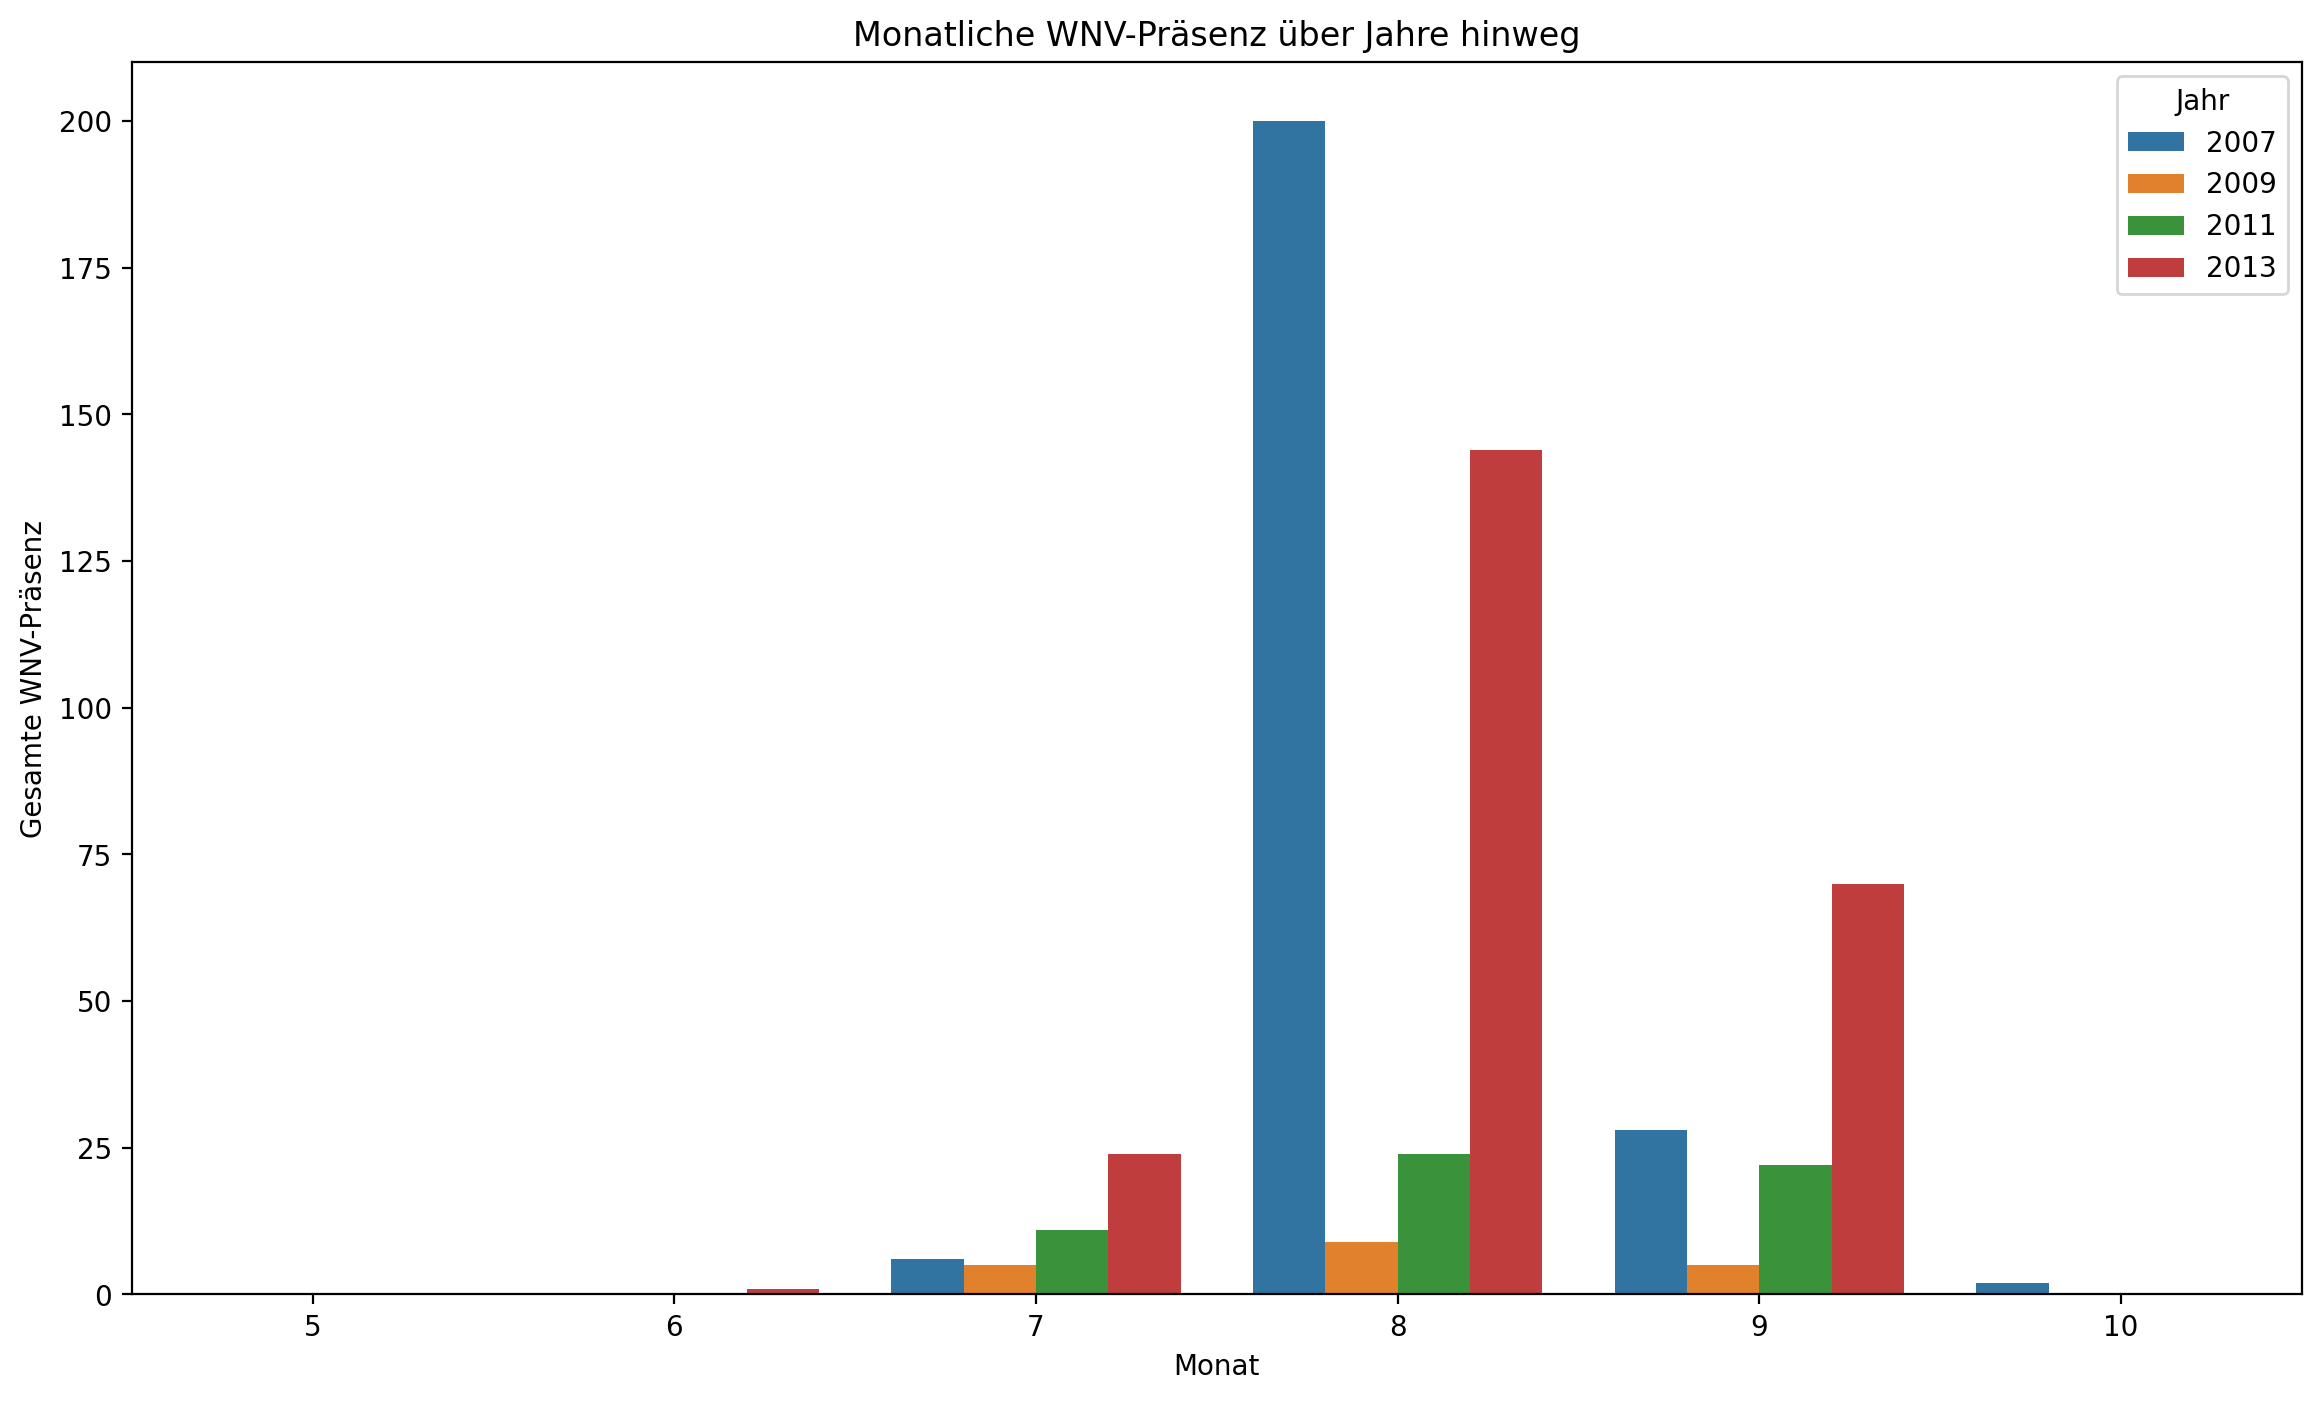

In [317]:
# Datei einlesen und Delimiter setzen
file_path = '../data/train.csv'
df = pd.read_csv(file_path)

# Konvertieren der 'Date'-Spalte in Datetime-Format
df['Date'] = pd.to_datetime(df['Date'], format='%Y-%m-%d')

# Extrahieren von Jahr und Monat
df['Year'] = df['Date'].dt.year
df['Month'] = df['Date'].dt.month

# Gruppieren nach Jahr und Monat und Summieren der Anzahl der WnvPresence
monthly_wnv_counts = df.groupby(['Year', 'Month']).agg({'WnvPresent': 'sum'}).reset_index()

# Bar-Chart erstellen
plt.figure(figsize=(14, 8))
sns.barplot(x='Month', y='WnvPresent', hue='Year', data=monthly_wnv_counts, palette='tab10')
plt.title('Monatliche WNV-Präsenz über Jahre hinweg')
plt.xlabel('Monat')
plt.ylabel('Gesamte WNV-Präsenz')
plt.legend(title='Jahr')
plt.show()

TODO: Korrelationsmatrix --> hatte ich probiert, kam dann leider nicht weiter, wie ich damit umgehen kann, dass die Daten, die ich für die Korrelation vergleichen will, nicht aus der gleichen File kommen. Muss mir das daher nochmal anschauen

- `train.csv` und `test.csv`: Training und Testdatensätze.

- `weather.csv`: Wetterdaten von 2007 bis 2014.

- `spray.csv`: GIS-Daten von Sprühaktionen in 2011 und 2013.


##### Visualisierung aller Traps in Map


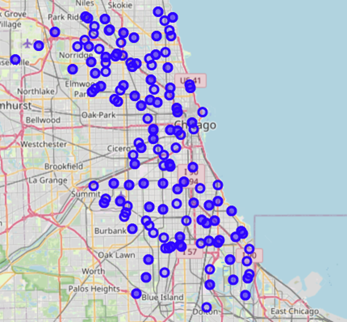

##### Spraybereich

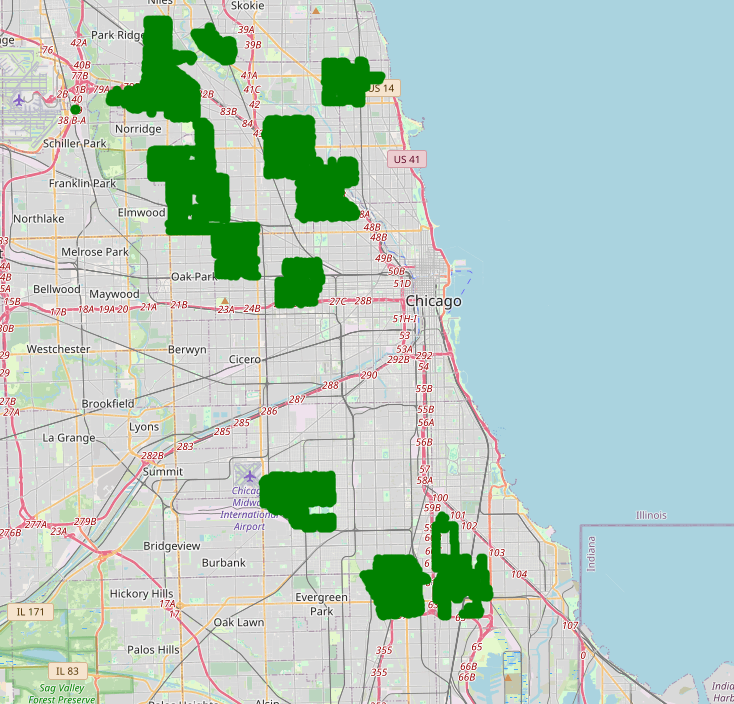

- `Date`: Datum des Tests.

- `Species`: Mückenart.

- `Trap`: ID der Falle.

- `NumMosquitos`: Anzahl der gefangenen Mücken.

- `WnvPresent`: WNV vorhanden (1: Ja, 0: Nein).

- `Latitude` und `Longitude`: Geografische Koordinaten.


<div style="color:red;">???? ⬇️<div> 

- Wäre es durchaus sinnvoller die Korrelationsmatrix in dem Schritt Data Preparation zwischen der Feature Extraction und Data Selection zu machen, um zu schauen ob die extrahierten Features z.B. höhre Korrelation aufweisen? -> (Streng genommen gehört das ja nicht zu Data Preparation und ist deswegen hier gelandet)

## Korrelationsmatrix

In [318]:
# Load datasets
train = pd.read_csv('../data/train.csv')
test = pd.read_csv('../data/test.csv')
weather = pd.read_csv('../data/weather.csv')
spray = pd.read_csv('../data/spray.csv')

Non-numeric columns in weather dataframe: []

Merged and Encoded Dataset
        Date   Latitude  Longitude  NumMosquitos  WnvPresent  Station  Tmax  \
0 2007-05-29  41.954690 -87.800991             1           0      1.5  88.0   
1 2007-05-29  41.954690 -87.800991             1           0      1.5  88.0   
2 2007-05-29  41.994991 -87.769279             1           0      1.5  88.0   
3 2007-05-29  41.974089 -87.824812             1           0      1.5  88.0   
4 2007-05-29  41.974089 -87.824812             4           0      1.5  88.0   

   Tmin  Tavg  Depart  ...  ResultDir  AvgSpeed  SprayCount  \
0  62.5  75.5    10.0  ...       17.0      6.95         0.0   
1  62.5  75.5    10.0  ...       17.0      6.95         0.0   
2  62.5  75.5    10.0  ...       17.0      6.95         0.0   
3  62.5  75.5    10.0  ...       17.0      6.95         0.0   
4  62.5  75.5    10.0  ...       17.0      6.95         0.0   

   Species_CULEX ERRATICUS  Species_CULEX PIPIENS  \
0                   

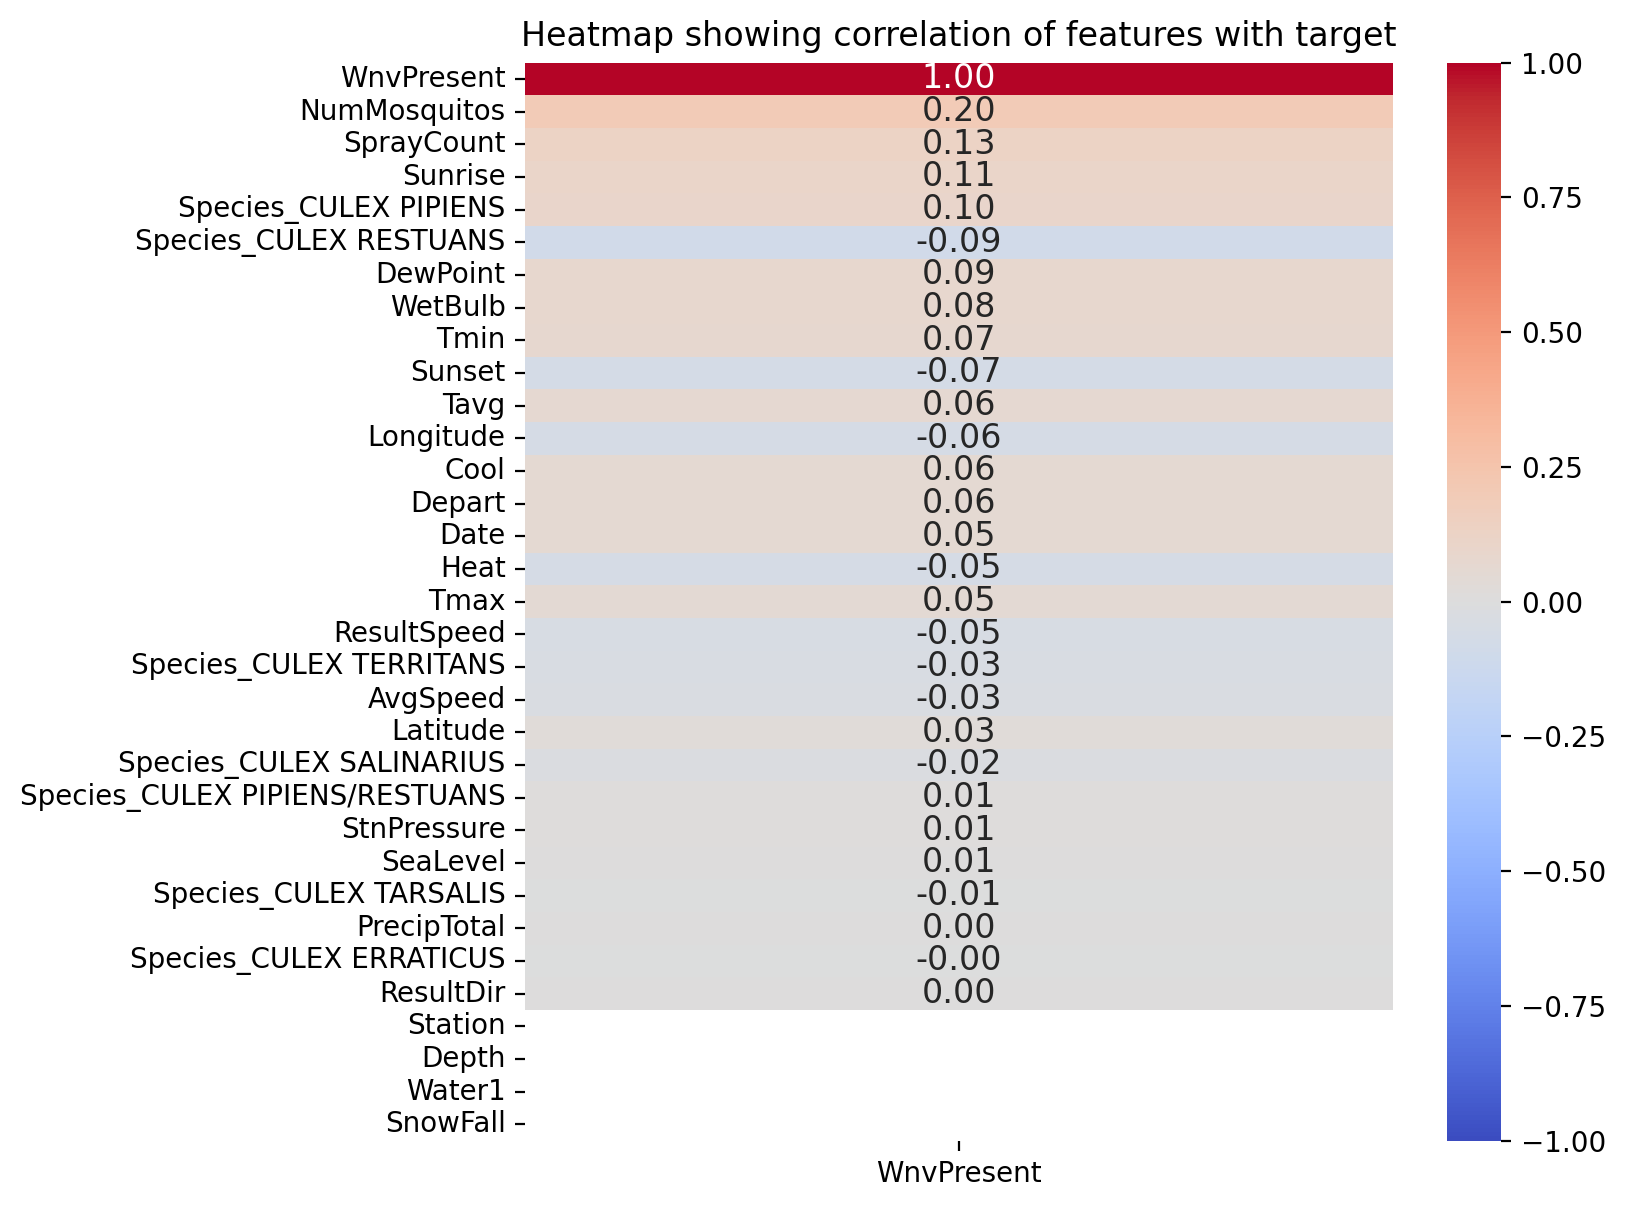

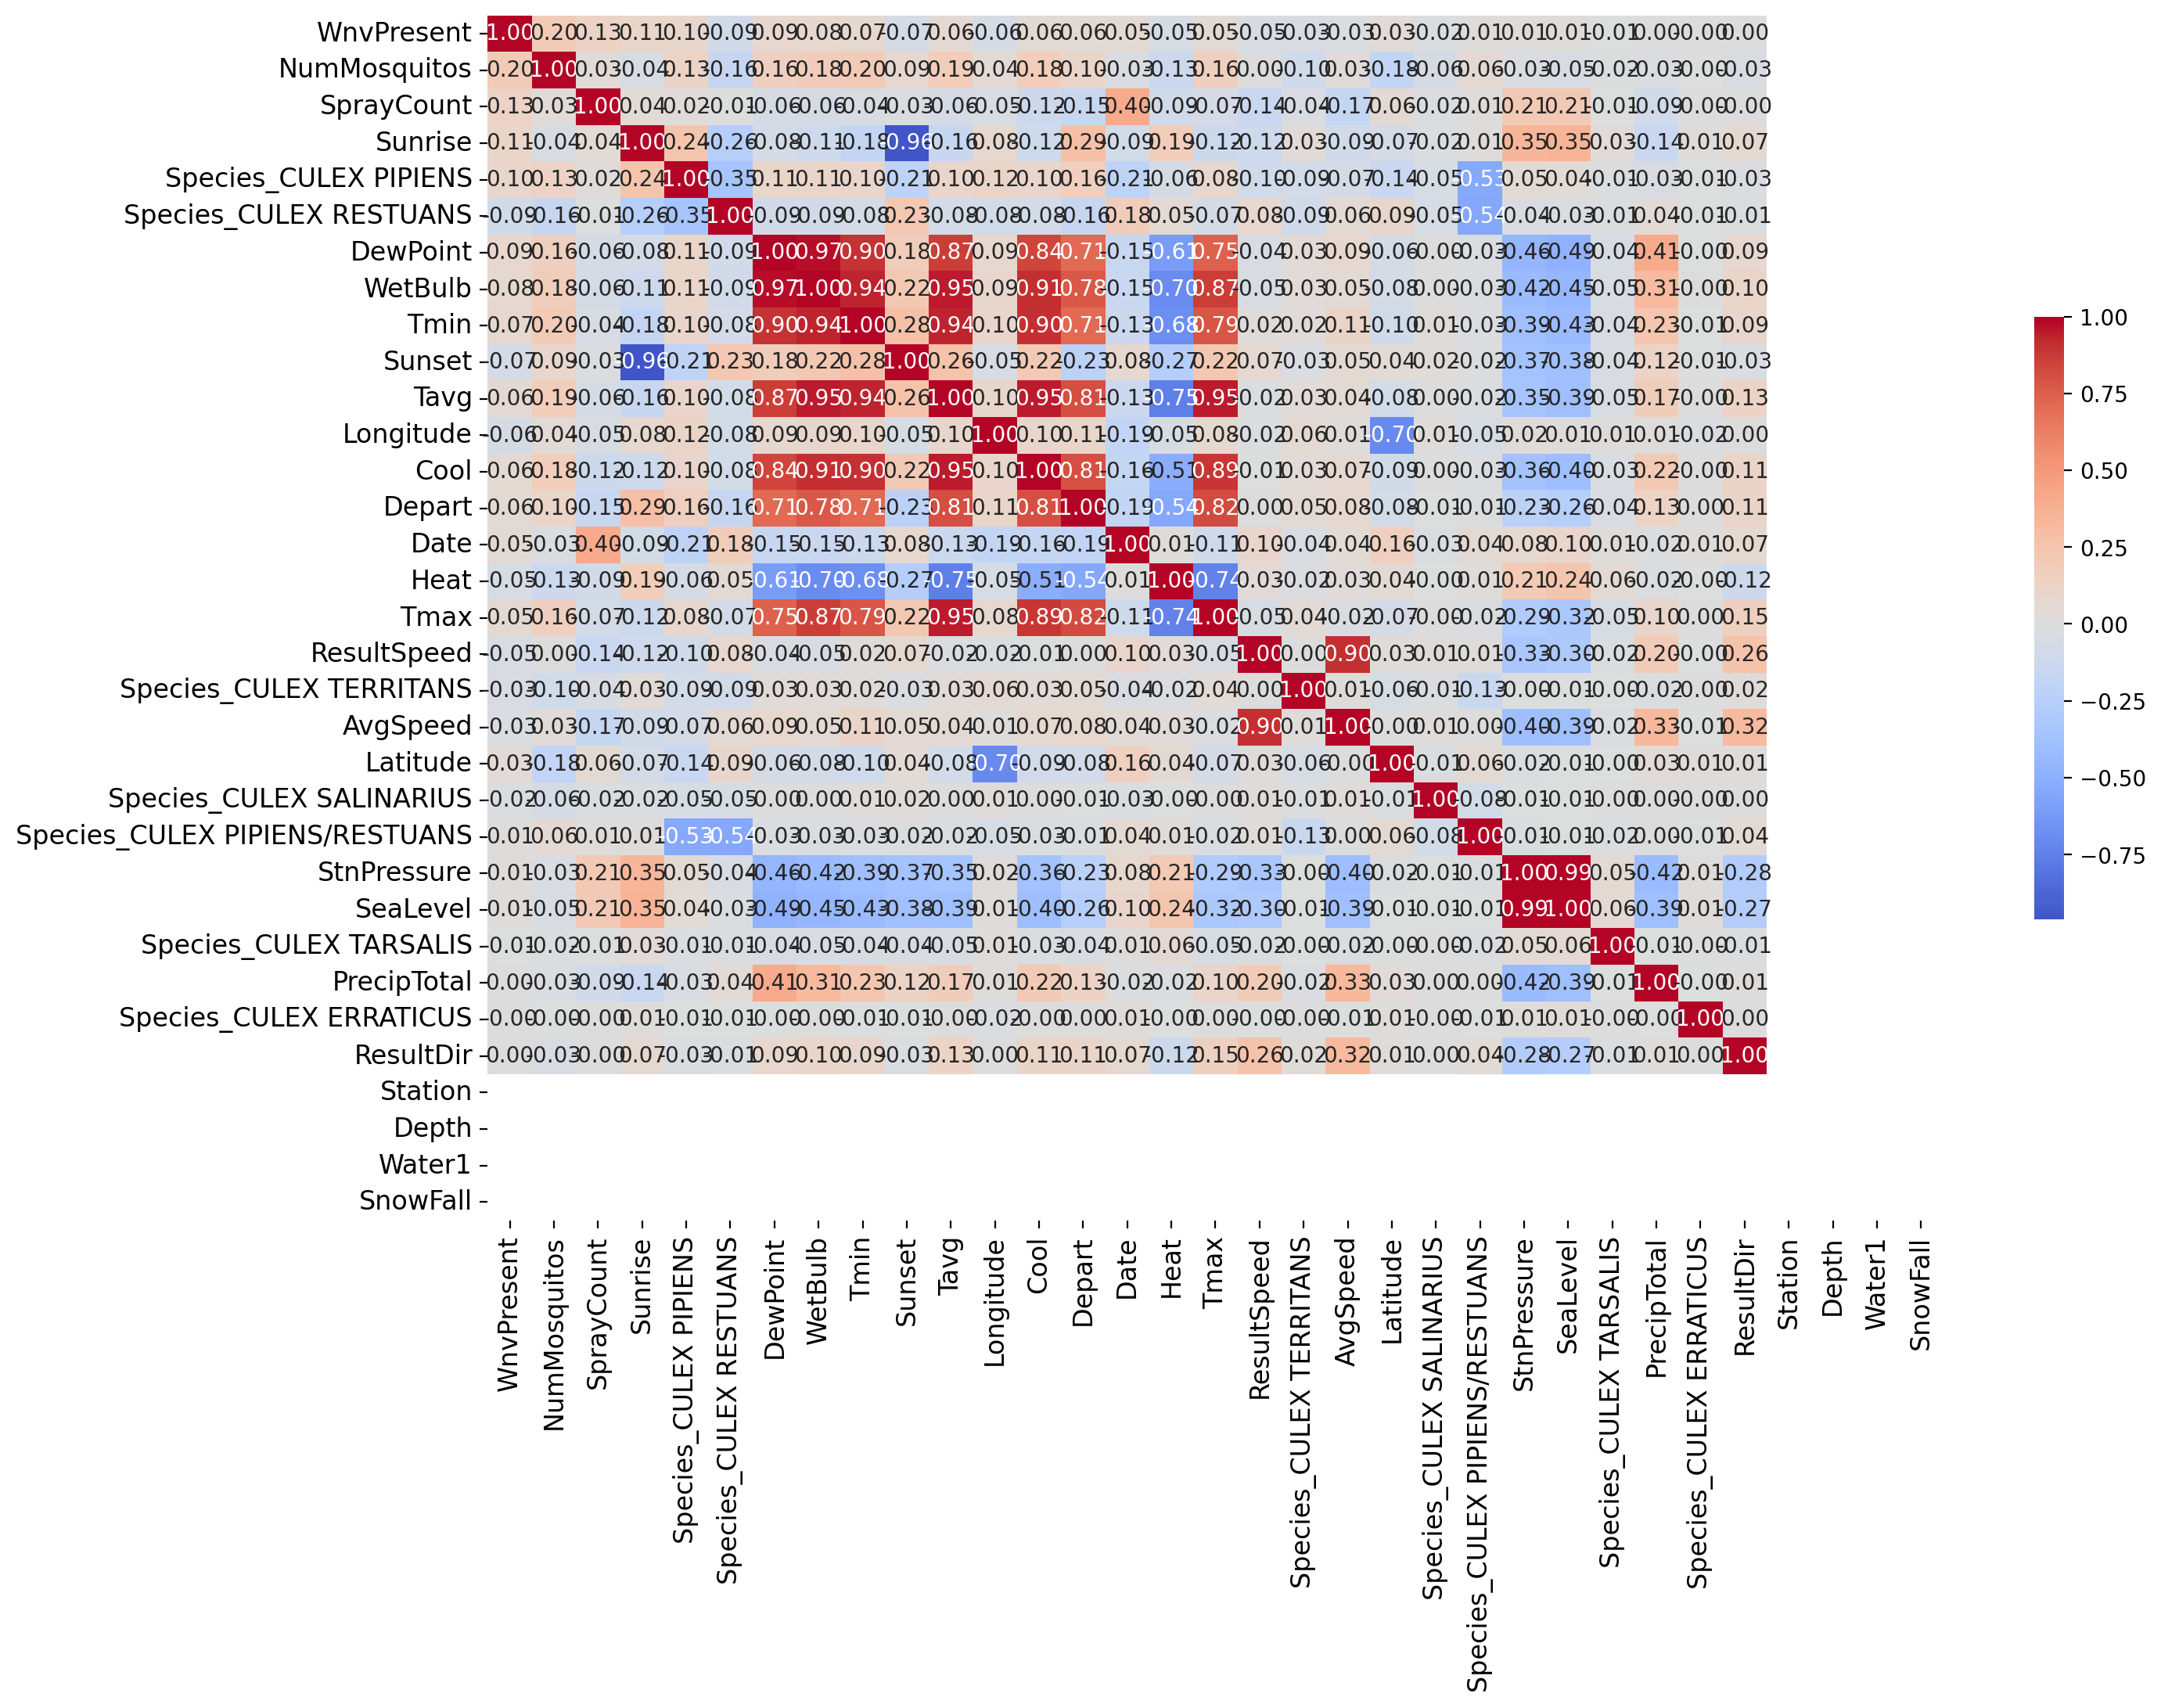

In [319]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Function to convert columns to numeric, coercing errors to NaN
def convert_to_numeric(df, columns):
    for column in columns:
        df[column] = pd.to_numeric(df[column], errors='coerce')
    return df

# Convert Date columns to datetime
train['Date'] = pd.to_datetime(train['Date'])
weather['Date'] = pd.to_datetime(weather['Date'])
spray['Date'] = pd.to_datetime(spray['Date'])


# Ensure 'Date' column is present
if 'Date' not in weather.columns:
    raise KeyError("'Date' column is missing from weather dataframe")
weather.drop(columns=['CodeSum'], inplace=True)
train.drop(columns=['Address', 'Block', 'Street', 'AddressNumberAndStreet', 'AddressAccuracy', 'Trap'], inplace=True)

# List of columns to convert to numeric in the weather dataframe
numeric_columns = ["Tmax", "Tmin", "Tavg", "Depart", "DewPoint", "WetBulb", 
                   "Heat", "Cool", "Depth", "Water1", "SnowFall", "PrecipTotal", 
                   "StnPressure", "SeaLevel", "ResultSpeed", "ResultDir", "AvgSpeed", "Sunset", "Sunrise"]

# Convert specified columns to numeric in the weather dataframe
weather = convert_to_numeric(weather, numeric_columns)

# Identify non-numeric columns in the weather dataframe, excluding 'Date'
non_numeric_columns = weather.select_dtypes(exclude='number').columns
non_numeric_columns = [col for col in non_numeric_columns if col != 'Date']
print(f"Non-numeric columns in weather dataframe: {non_numeric_columns}")

# Convert non-numeric columns to numeric using one-hot encoding
# Retain the 'Date' column for the grouping operation
weather_encoded = pd.get_dummies(weather, columns=non_numeric_columns)

# Ensure 'Date' column is still present
if 'Date' not in weather_encoded.columns:
    raise KeyError("'Date' column is missing from weather_encoded dataframe after encoding")

# Aggregate numeric weather data by date
weather_agg = weather_encoded.groupby('Date').mean().reset_index()

# Merge train with aggregated weather data
train_weather = pd.merge(train, weather_agg, on='Date', how='left')

# Aggregate spray data by date
spray_agg = spray.groupby('Date').size().reset_index(name='SprayCount')

# Merge with aggregated spray data
train_weather_spray = pd.merge(train_weather, spray_agg, on='Date', how='left')

# Fill NaN values in SprayCount
train_weather_spray['SprayCount'].fillna(0, inplace=True)

# train_weather_spray.drop(columns=['CodeSum'], inplace=True)

# Perform one-hot encoding for all categorical variables in the train dataset
train_weather_spray_encoded = pd.get_dummies(train_weather_spray)

# Display the merged and encoded dataset
print("\nMerged and Encoded Dataset")
print(train_weather_spray_encoded.head())

# Select all columns for correlation matrix
numeric_data = train_weather_spray_encoded

# Calculate the correlation matrix
correlation_matrix = numeric_data.corr()

# Get the top 20 most correlating values with 'WnvPresent'
corr = correlation_matrix['WnvPresent'].abs().sort_values(ascending=False)  # 21 because 'WnvPresent' will be included
correlation = corr.index

# Ensure 'WnvPresent' is the first column and row
correlation = ['WnvPresent'] + [col for col in correlation if col != 'WnvPresent']

# Reorder the correlation matrix to include only the top 20 columns
reordered_corr_matrix = correlation_matrix.loc[correlation, correlation]

# Display the reordered correlation matrix
print("\nTop 20 Correlating Features with WnvPresent")
print(reordered_corr_matrix)
plt.figure(figsize=(7, 7))
plt.title("Heatmap showing correlation of features with target")
sns.heatmap(reordered_corr_matrix[["WnvPresent"]], annot=True, cmap="coolwarm", 
           fmt=".2f", annot_kws={"size":12}, vmin=-1, vmax=1)
plt.show()
# Visualize the reordered correlation matrix
plt.figure(figsize=(15, 10))
sns.heatmap(reordered_corr_matrix, annot=True, fmt=".2f", cmap='coolwarm', center=0,
            annot_kws={"size": 10}, cbar_kws={"shrink": 0.5})
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.show()